In [4]:
#import packages and dataset
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

data_path = '../../data/cleaned_riot_data/league_combined_with_chall_cleaned.csv'
combined_league_ranks = pd.read_csv(data_path, index_col=None)

In [5]:
"""
Small cleaning step similar to what I did in feature selection 
to normalize time-dependent variables.
"""

#normalize variables that are time-dependent with the time variable
#do this for variables: kills, deaths, dmgObj, dmgTurr, vision_score, totalDmg, 
#totalDmgTaken, totalMinions, and gold
combined_league_ranks['kills/min'] = combined_league_ranks['kills']/combined_league_ranks['time']
combined_league_ranks['deaths/min'] = combined_league_ranks['deaths']/combined_league_ranks['time']
combined_league_ranks['dmgObj/min'] = combined_league_ranks['dmgObj']/combined_league_ranks['time']
combined_league_ranks['dmgTurr/min'] = combined_league_ranks['dmgTurr']/combined_league_ranks['time']
combined_league_ranks['vision_score/min'] = combined_league_ranks['vision_score']/combined_league_ranks['time']
combined_league_ranks['dmg/min'] = combined_league_ranks['totalDmg']/combined_league_ranks['time']
combined_league_ranks['dmgTaken/min'] = combined_league_ranks['totalDmgTaken']/combined_league_ranks['time']
combined_league_ranks['minions/min'] = combined_league_ranks['totalMinions']/combined_league_ranks['time']
combined_league_ranks['gold/min'] = combined_league_ranks['gold']/combined_league_ranks['time']


#remove the time-dependent columns that did not include time as a rate
combined_league_ranks = combined_league_ranks.drop('kills', axis=1)
combined_league_ranks = combined_league_ranks.drop('deaths', axis=1)
combined_league_ranks = combined_league_ranks.drop('dmgObj', axis=1)
combined_league_ranks = combined_league_ranks.drop('dmgTurr', axis=1)
combined_league_ranks = combined_league_ranks.drop('vision_score', axis=1)
combined_league_ranks = combined_league_ranks.drop('totalDmg', axis=1)
combined_league_ranks = combined_league_ranks.drop('totalDmgTaken', axis=1)
combined_league_ranks = combined_league_ranks.drop('totalMinions', axis=1)
combined_league_ranks = combined_league_ranks.drop('gold', axis=1)

#remove non-numerical columns and time columns
combined_league_ranks = combined_league_ranks.drop('time', axis=1)
combined_league_ranks = combined_league_ranks.drop('position', axis=1)
combined_league_ranks = combined_league_ranks.drop('win', axis=1)

#remove temporarily the class label column "rank" to add to later
rank_col = combined_league_ranks.pop("rank")

In [6]:
"""
Apply PCA to the dataset now WITHOUT setting how many principal components.

This will show the same number of principal components as the number of features.
"""

#define PCA() as instance
#without defining parameters in PCA process first
pca = PCA()

#fit and transform the dataset with PCA 
combined_pca = pca.fit_transform(combined_league_ranks)

#reintroduce the class label (ranks) according to each row.
#the rows should be in the same order as before.
combined_pca = pd.DataFrame(combined_pca)
combined_pca['rank'] = rank_col #will be helpful in visualizing

C:\Users\xusha\AppData\Local\Temp\ipykernel_10460\921857819.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset[0], subset[1], c=map_color_rank[label], label=label)


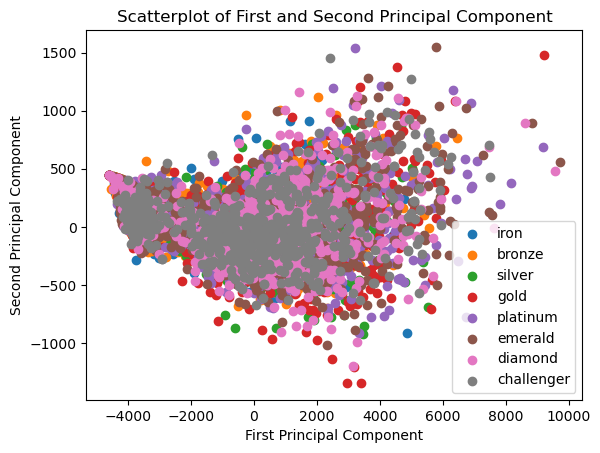

In [7]:
"""
Visualize initial PCA done on the dataset using first and second principal component.
"""
#assign color to each class label
each_rank = rank_col.unique()
diff_colors = plt.cm.tab10(range(len(each_rank)))
map_color_rank = dict(zip(each_rank, diff_colors))
#now map back to the combined_pca df
combined_pca['rank color'] = combined_pca['rank'].map(map_color_rank)

#plot the PCA transformed dataset into scatterplot
for label in each_rank:
    #subset dataset with each label
    subset = combined_pca[combined_pca['rank']==label]
    plt.scatter(subset[0], subset[1], c=map_color_rank[label], label=label)
#title, labels, and legend
plt.title('Scatterplot of First and Second Principal Component')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()

#save as .png
plt.savefig('all_pc_TRANSFORMED.png')

plt.show()

In [8]:
"""
The loadings of each principal component can help visualize how each feature of the original
dataset contributes to the principal component.

.components_ of my PCA transformations shows the loadings of each principal component.

Each components' loadings = each feature's loading impact on creating the principal component.
"""

#select the first principal component then get loadings
loadings = pca.components_[0]

#save the loadings into dataframe
load_df = pd.DataFrame({'features': combined_league_ranks.columns, 'loadings': loadings})
#print the loads for each feature
print(load_df)

           features  loadings
0         kills/min  0.000035
1        deaths/min -0.000005
2        dmgObj/min  0.132264
3       dmgTurr/min  0.016178
4  vision_score/min -0.000088
5           dmg/min  0.988058
6      dmgTaken/min  0.071493
7       minions/min  0.000296
8          gold/min  0.029582


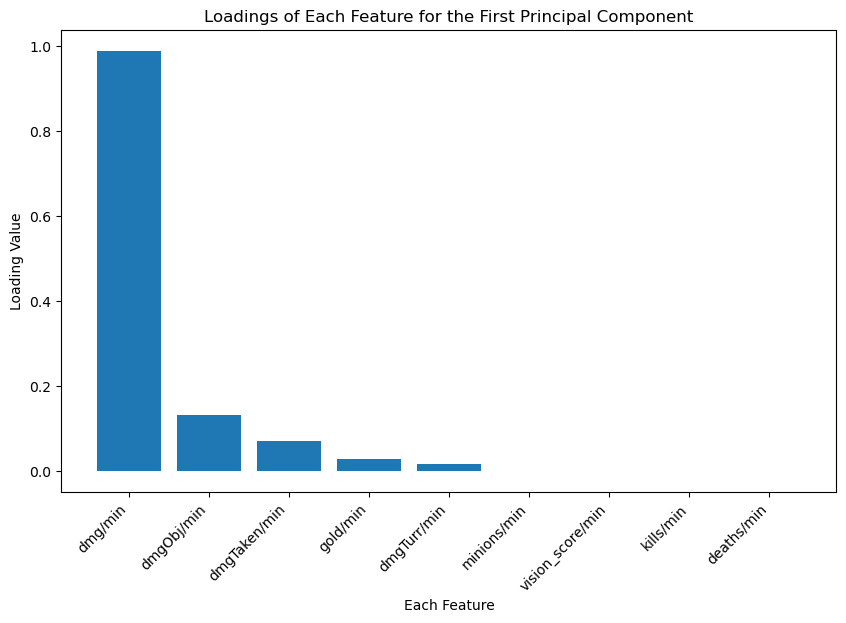

In [9]:
"""
The loadings shown from the first principal component shows that basically all features have
positive contributions to the principal component generation. The negative loadings are 
practically zero so use absolute value to plot/visualize.
"""

#first convert loadings to absolute value as all negatives are basically 0
load_df['absolute loads'] = np.abs(load_df['loadings'])
#next sort by absolute loadings from highest magnitude to lowest
sorted_load = load_df.sort_values(by='absolute loads', ascending=False)

#now plot with features as x-axis and the loadings of each feature
plt.figure(figsize=(10, 6))
plt.bar(sorted_load['features'], sorted_load['loadings'])
plt.title('Loadings of Each Feature for the First Principal Component')
plt.xlabel('Each Feature')
plt.ylabel('Loading Value')
plt.xticks(rotation=45, ha='right')

#save plot as .png
plt.savefig('sorted_loads_PC.png', bbox_inches='tight')

plt.show()

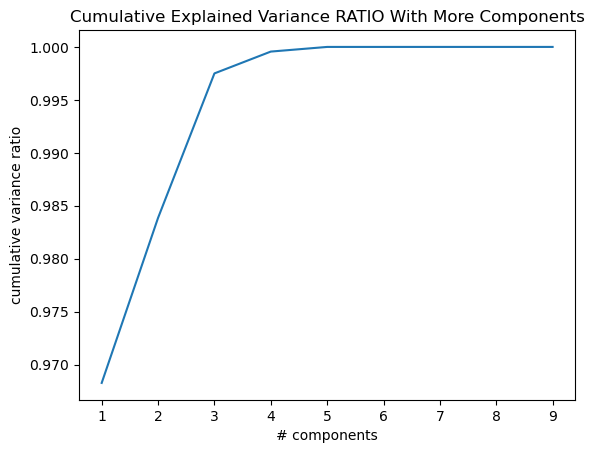

In [16]:
"""
To determine the optimal number of principal components we will want the number of principal
components where the cumulative variance ratio of all the principal components is diminishing.
This can be determined with elbow method of the cumulative sum.
"""
#get the explained_variance_ratio_ and plot the cumulative sum of it
plt.plot(np.arange(1,10), np.cumsum(pca.explained_variance_ratio_))

#x should be simply indexed by the number of principal comps
plt.title('Cumulative Explained Variance RATIO With More Components')
plt.xlabel('# components')
plt.ylabel('cumulative variance ratio')

#save as .png
plt.savefig('optimal_PC_num.png', bbox_inches='tight')

plt.show()

#it seem the elbow first appears at 3 principal components